# Predict single footballer future points

## Import merged_gw data from 2020-21 season

In [1082]:
import os
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [1083]:
data_path = os.path.dirname(os.getcwd()) + '\\data'
merged_gw_2021_path = data_path + '\\2020-21\\gws\\merged_gw.csv'

In [1084]:
merged_gw = pd.read_csv(merged_gw_2021_path, encoding='latin-1', )

In [1085]:
merged_gw.head()

,name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,element,...,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW
0,Aaron Connolly,FWD,Brighton,0.5,0,0,-3,0,0.3,78,...,1,32.0,1,0,0,0,55,True,0,1
1,Aaron Cresswell,DEF,West Ham,2.1,0,0,11,0,11.2,435,...,0,0.0,1,0,0,0,50,True,0,1
2,Aaron Mooy,MID,Brighton,0.0,0,0,0,0,0.0,60,...,1,0.0,0,0,0,0,50,True,0,1
3,Aaron Ramsdale,GK,Sheffield Utd,2.5,0,0,12,0,0.0,483,...,0,0.0,1,0,0,0,50,True,0,1
4,Abdoulaye DoucourÃ©,MID,Everton,1.3,0,0,20,1,44.6,512,...,0,4.0,3,0,0,0,55,False,0,1


In [1086]:
# sort rows by column 'GW' ascending
merged_gw.sort_values(by='GW', inplace=True)

## Extract Jamie Vardy data

In [1087]:
vardy_data = merged_gw[merged_gw['name'] == 'Jamie Vardy']

In [1088]:
vardy_data.head()

,name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,element,...,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW
183,Jamie Vardy,FWD,Leicester,4.8,0,3,52,1,10.3,224,...,0,36.0,13,0,0,0,100,False,0,1
660,Jamie Vardy,FWD,Leicester,8.0,0,0,6,0,11.2,224,...,4,22.0,2,226309,303351,77042,101,True,0,2
1207,Jamie Vardy,FWD,Leicester,10.2,0,3,82,0,0.5,224,...,2,71.0,17,-247620,71441,319061,100,False,0,3
1764,Jamie Vardy,FWD,Leicester,9.0,0,0,-2,0,1.4,224,...,0,14.0,2,296313,427289,130976,101,True,0,4
2335,Jamie Vardy,FWD,Leicester,4.3,0,0,0,0,0.0,224,...,0,0.0,0,-30736,210612,241348,101,True,0,5


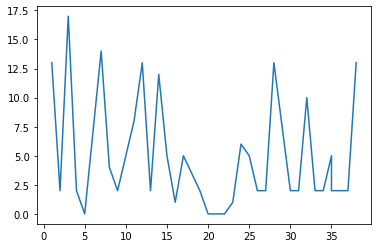

In [1089]:
plt.plot(vardy_data['GW'], vardy_data['total_points']);

## Data preprocessing

In [1090]:
cleaned_data = vardy_data.drop(['name', 'position', 'team', 'element', 'fixture', 'kickoff_time', 'saves', 'penalties_saved', 'round', 'GW'], axis=1)

In [1091]:
# change was_home column to binary
cleaned_data['was_home'] = cleaned_data['was_home'].map({True: 1, False: 0})

In [1092]:
# one hot encode 'opponent_team' column
cleaned_data = pd.get_dummies(cleaned_data, columns=['opponent_team'], drop_first=True)

In [1093]:
cleaned_data.head()

,xP,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,...,opponent_team_11,opponent_team_12,opponent_team_13,opponent_team_14,opponent_team_15,opponent_team_16,opponent_team_17,opponent_team_18,opponent_team_19,opponent_team_20
183,4.8,0,3,52,1,10.3,0,2,11.8,71.2,...,0,0,0,0,0,0,0,1,0,0
660,8.0,0,0,6,0,11.2,2,0,3.6,2.6,...,0,0,0,0,0,0,0,0,0,0
1207,10.2,0,3,82,0,0.5,2,3,17.7,105.2,...,0,1,0,0,0,0,0,0,0,0
1764,9.0,0,0,-2,0,1.4,3,0,1.8,2.6,...,0,0,0,0,0,0,0,0,1,0
2335,4.3,0,0,0,0,0.0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [1094]:
train = cleaned_data[:30]
test = cleaned_data[30:]

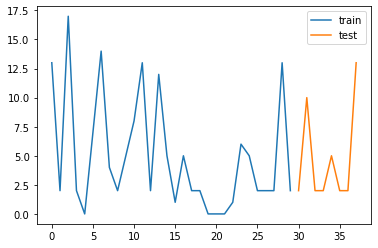

In [1095]:
plt.plot(range(len(train)), train['total_points'], label='train')
plt.plot(range(len(train), len(train + test)), test['total_points'], label='test')
plt.legend();

In [1096]:
X_train = train.drop('total_points', axis=1).copy()
y_train = train[['total_points']].copy()

print(X_train.shape, y_train.shape)

(30, 42) (30, 1)


In [1097]:
Xscaler = MinMaxScaler(feature_range=(0, 1))
scaled_X_train = Xscaler.fit_transform(X_train)
print(X_train.shape)

Yscaler = MinMaxScaler(feature_range=(0, 1))
scaled_y_train = Yscaler.fit_transform(y_train)
print(scaled_y_train.shape)

scaled_y_train = scaled_y_train.reshape(-1)
print(scaled_y_train.shape)

scaled_y_train = np.insert(scaled_y_train, 0, 0)
scaled_y_train = np.delete(scaled_y_train, -1)

(30, 42)
(30, 1)
(30,)


In [1098]:
n_input = 3 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features = X_train.shape[1] # how many predictors/Xs/features we have to predict y
b_size = 3 # Number of timeseries samples in each batch
generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=n_input, batch_size=b_size)

print(generator[0][0].shape)

(3, 3, 42)


## Build LSTM model

In [1099]:
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_45 (LSTM)              (None, 150)               115800    
                                                                 
 dense_45 (Dense)            (None, 1)                 151       
                                                                 
Total params: 115,951
Trainable params: 115,951
Non-trainable params: 0
_________________________________________________________________


In [1100]:
model.fit_generator(generator,epochs=20)

Epoch 1/20


C:\Users\gracj\AppData\Local\Temp\ipykernel_2224\2163120762.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=20)


9/9 [==============================] - 1s 2ms/step - loss: 0.0977
Epoch 2/20
9/9 [==============================] - 0s 2ms/step - loss: 0.0660
Epoch 3/20
9/9 [==============================] - 0s 2ms/step - loss: 0.0523
Epoch 4/20
9/9 [==============================] - 0s 2ms/step - loss: 0.0414
Epoch 5/20
9/9 [==============================] - 0s 2ms/step - loss: 0.0299
Epoch 6/20
9/9 [==============================] - 0s 2ms/step - loss: 0.0207
Epoch 7/20
9/9 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 8/20
9/9 [==============================] - 0s 2ms/step - loss: 0.0056
Epoch 9/20
9/9 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 10/20
9/9 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 11/20
9/9 [==============================] - 0s 2ms/step - loss: 8.8837e-04
Epoch 12/20
9/9 [==============================] - 0s 2ms/step - loss: 5.3869e-04
Epoch 13/20
9/9 [==============================] - 0s 2ms/step - loss: 4.300

In [1101]:
X_test = test.drop('total_points', axis=1).copy()
scaled_X_test = Xscaler.transform(X_test)

test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

print(test_generator[0][0].shape)

y_pred_scaled = model.predict(test_generator)
y_pred = Yscaler.inverse_transform(y_pred_scaled)


print(test[['total_points']].values[n_input:].reshape(-1))
print(y_pred.ravel())

y_pred_0 = y_pred

results_0 = pd.DataFrame({'y_true':test[['total_points']].values[n_input:].reshape(-1),'y_pred':y_pred.ravel()})
print(results_0)

(3, 3, 42)
[ 2  5  2  2 13]
[2.8503518 2.6551204 5.8073173 1.8734047 2.2187634]
   y_true    y_pred
0       2  2.850352
1       5  2.655120
2       2  5.807317
3       2  1.873405
4      13  2.218763


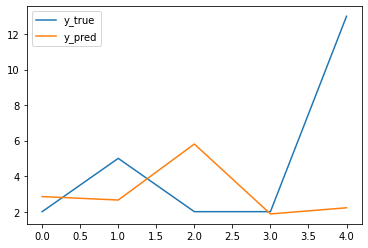

In [1102]:
results_0.plot();

## Add Jamie Vardy understat data and train new model

In [1103]:
data_path = os.path.dirname(os.getcwd()) + '\\data'
vardy_understat = data_path + '\\2021-22\\understat\\Jamie_Vardy_755.csv'
vardy_understat = pd.read_csv(vardy_understat, encoding='latin-1', )
vardy_understat.head()

,goals,shots,xG,time,position,h_team,a_team,h_goals,a_goals,date,id,season,roster_id,xA,assists,key_passes,npg,npxG,xGChain,xGBuildup
0,0,0,0.000000,62,FW,Leicester,Leeds,1,0,2022-03-05,16648,2021,517260,0.000000,0,0,0,0.000000,0.000000,0.000000
1,1,2,0.474730,16,Sub,Burnley,Leicester,0,2,2022-03-01,16588,2021,517091,0.087236,1,2,1,0.474730,0.561967,0.000000
2,0,2,0.149755,90,FW,Leicester,Liverpool,1,0,2021-12-28,16573,2021,505323,0.320443,0,1,0,0.149755,0.470198,0.000000
3,0,0,0.000000,22,Sub,Aston Villa,Leicester,2,1,2021-12-05,16516,2021,500887,0.000000,0,0,0,0.000000,0.000000,0.000000
4,0,3,0.508952,90,FW,Southampton,Leicester,2,2,2021-12-01,16514,2021,499112,0.101893,0,2,0,0.508952,0.594523,0.160227


In [1104]:
# clean what's after "T" in the kickoff_time column from vardy_data
vardy_data['date'] = vardy_data['kickoff_time'].str.split('T').str[0]
vardy_data.drop(['kickoff_time'], axis=1, inplace=True)

C:\Users\gracj\AppData\Local\Temp\ipykernel_2224\4273698592.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vardy_data['date'] = vardy_data['kickoff_time'].str.split('T').str[0]
C:\Users\gracj\AppData\Local\Temp\ipykernel_2224\4273698592.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vardy_data.drop(['kickoff_time'], axis=1, inplace=True)


In [1105]:
vardy_data = vardy_data.merge(vardy_understat, on='date', how='left')

In [1106]:
vardy_data.columns

Index(['name', 'position_x', 'team', 'xP', 'assists_x', 'bonus', 'bps',
       'clean_sheets', 'creativity', 'element', 'fixture', 'goals_conceded',
       'goals_scored', 'ict_index', 'influence', 'minutes', 'opponent_team',
       'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards',
       'round', 'saves', 'selected', 'team_a_score', 'team_h_score', 'threat',
       'total_points', 'transfers_balance', 'transfers_in', 'transfers_out',
       'value', 'was_home', 'yellow_cards', 'GW', 'date', 'goals', 'shots',
       'xG', 'time', 'position_y', 'h_team', 'a_team', 'h_goals', 'a_goals',
       'id', 'season', 'roster_id', 'xA', 'assists_y', 'key_passes', 'npg',
       'npxG', 'xGChain', 'xGBuildup'],
      dtype='object')

In [1107]:
vardy_data = vardy_data.drop(['goals', 'time', 'position_y', 'h_team', 'a_team', 'h_goals', 'a_goals', 'id', 'season', 'roster_id', 'assists_y'], axis=1)

In [1108]:
# insert 0's for missing values
vardy_data.fillna(0, inplace=True)

In [1109]:
vardy_data.head()

,name,position_x,team,xP,assists_x,bonus,bps,clean_sheets,creativity,element,...,GW,date,shots,xG,xA,key_passes,npg,npxG,xGChain,xGBuildup
0,Jamie Vardy,FWD,Leicester,4.8,0,3,52,1,10.3,224,...,1,2020-09-13,2.0,1.522338,0.066219,1.0,0.0,0.000000,0.112795,0.046576
1,Jamie Vardy,FWD,Leicester,8.0,0,0,6,0,11.2,224,...,2,2020-09-20,1.0,0.089161,0.096211,1.0,0.0,0.089161,0.277284,0.091911
2,Jamie Vardy,FWD,Leicester,10.2,0,3,82,0,0.5,224,...,3,2020-09-27,3.0,1.965583,0.000000,0.0,1.0,0.443245,0.521428,0.078183
3,Jamie Vardy,FWD,Leicester,9.0,0,0,-2,0,1.4,224,...,4,2020-10-04,1.0,0.302199,0.000000,0.0,0.0,0.302199,0.302199,0.000000
4,Jamie Vardy,FWD,Leicester,4.3,0,0,0,0,0.0,224,...,5,2020-10-18,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000


## Do data preprocessing and build model again, with understat data

(30, 50) (30, 1)
(30, 50)
(30, 1)
(30,)
(3, 3, 50)
Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_46 (LSTM)              (None, 150)               120600    
                                                                 
 dense_46 (Dense)            (None, 1)                 151       
                                                                 
Total params: 120,751
Trainable params: 120,751
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20


C:\Users\gracj\AppData\Local\Temp\ipykernel_2224\95176939.py:45: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=20)


9/9 [==============================] - 1s 2ms/step - loss: 0.0890
Epoch 2/20
9/9 [==============================] - 0s 2ms/step - loss: 0.0522
Epoch 3/20
9/9 [==============================] - 0s 2ms/step - loss: 0.0332
Epoch 4/20
9/9 [==============================] - 0s 2ms/step - loss: 0.0223
Epoch 5/20
9/9 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 6/20
9/9 [==============================] - 0s 2ms/step - loss: 0.0073
Epoch 7/20
9/9 [==============================] - 0s 2ms/step - loss: 0.0046
Epoch 8/20
9/9 [==============================] - 0s 3ms/step - loss: 0.0022
Epoch 9/20
9/9 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 10/20
9/9 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 11/20
9/9 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 12/20
9/9 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 13/20
9/9 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 

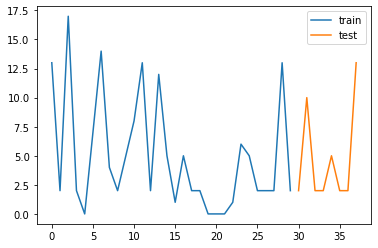

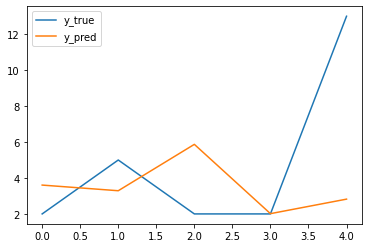

In [1110]:
## Data preprocessing
cleaned_data = vardy_data.drop(
    ['name', 'position_x', 'team', 'element', 'fixture', 'date', 'saves', 'penalties_saved', 'round', 'GW'],
    axis=1)

# change was_home column to binary
cleaned_data['was_home'] = cleaned_data['was_home'].map({True: 1, False: 0})

# one hot encode 'opponent_team' column
cleaned_data = pd.get_dummies(cleaned_data, columns=['opponent_team'], drop_first=True)
train = cleaned_data[:30]
test = cleaned_data[30:]
plt.plot(range(len(train)), train['total_points'], label='train')
plt.plot(range(len(train), len(train + test)), test['total_points'], label='test')
plt.legend();
X_train = train.drop('total_points', axis=1).copy()
y_train = train[['total_points']].copy()

print(X_train.shape, y_train.shape)
Xscaler = MinMaxScaler(feature_range=(0, 1))
scaled_X_train = Xscaler.fit_transform(X_train)
print(X_train.shape)

Yscaler = MinMaxScaler(feature_range=(0, 1))
scaled_y_train = Yscaler.fit_transform(y_train)
print(scaled_y_train.shape)

scaled_y_train = scaled_y_train.reshape(-1)
print(scaled_y_train.shape)

scaled_y_train = np.insert(scaled_y_train, 0, 0)
scaled_y_train = np.delete(scaled_y_train, -1)
n_input = 3  #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features = X_train.shape[1]  # how many predictors/Xs/features we have to predict y
b_size = 3  # Number of timeseries samples in each batch
generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=n_input, batch_size=b_size)

print(generator[0][0].shape)
## Build LSTM model
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()
model.fit_generator(generator, epochs=20)
X_test = test.drop('total_points', axis=1).copy()
scaled_X_test = Xscaler.transform(X_test)

test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

print(test_generator[0][0].shape)

y_pred_scaled = model.predict(test_generator)
y_pred = Yscaler.inverse_transform(y_pred_scaled)

y_pred_1 = y_pred

print(test[['total_points']].values[n_input:].reshape(-1))
print(y_pred.ravel())

results_1 = pd.DataFrame({'y_true': test[['total_points']].values[n_input:].reshape(-1), 'y_pred': y_pred.ravel()})
print(results_1)
results_1.plot();

## Compare predictions with understat data and without

   y_true  y_pred_without  y_pred_understat
0       2        2.850352          3.604415
1       5        2.655120          3.290300
2       2        5.807317          5.870966
3       2        1.873405          2.014907
4      13        2.218763          2.822581


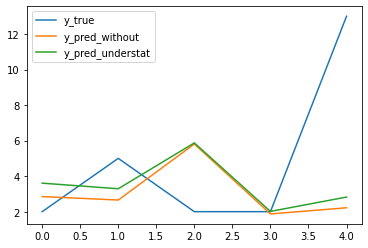

In [1111]:
results_compare = pd.DataFrame({'y_true': test[['total_points']].values[n_input:].reshape(-1), 'y_pred_without': y_pred_0.ravel(), 'y_pred_understat': y_pred_1.ravel()})
print(results_compare)
results_compare.plot();